In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# silence Future Warning
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [150]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
import pickle
import time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from collections import defaultdict

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


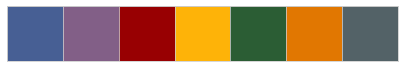

In [5]:
# import custom palette
import my_palette as mp

In [6]:
# read in actor dataset
df = pd.read_json('capstone1_ds.json')

In [7]:
# observe dimensionality of dataset
df.shape

(11693, 28)

In [8]:
# separate data into features and target
X = df.drop('actor_value', axis=1)
y = df['actor_value']

In [9]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [10]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

In [11]:
gpu_params = {'tree_method':'gpu_hist', 
              'predictor':'gpu_predictor',
              'sampling_method':'gradient_based', 
              'deterministic_histogram':'False'}

In [12]:
def get_base_model(features, target):
    """Return base XGBoost regressor model"""
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=27, n_jobs=-1)
    model.fit(features, target)
    
    return model

In [13]:
def get_params(model):
    """Return hyperparameters of interest from regressor"""
    series = pd.Series(
        model.get_params(), name='model_params').drop(
        ['base_score', 'booster', 'importance_type', 'missing', 'n_jobs', 'nthread', 
         'objective', 'random_state', 'scale_pos_weight', 'seed', 'silent', 'verbosity'])
    
    return series

In [14]:
# instantiate base model for given target and get parameters
base_model = get_base_model(X_train, y_train)
get_params(base_model)

colsample_bylevel      1
colsample_bynode       1
colsample_bytree       1
gamma                  0
learning_rate        0.1
max_delta_step         0
max_depth              3
min_child_weight       1
n_estimators         100
reg_alpha              0
reg_lambda             1
subsample              1
Name: model_params, dtype: object

In [15]:
def get_cv_adj_r2(features, target, model):
    """Return cross-validation average adjusted R2 score and adjusted R2 score range"""
    cv_results = cross_val_score(model, features, target, cv=10, n_jobs=-1)
    
    n = features.shape[0]
    p = features.shape[1]
    adj_r2 = 1 - (1 - cv_results) * ((n - 1)  / (n - p - 1))

    # get range of scores
    results_range = (np.min(adj_r2), np.max(adj_r2))
    # get average score and round to 5 decimal places
    ave_result = np.mean(adj_r2)

    return f'Average Adjusted R2 Score: {ave_result:.4f}, Range: {results_range[0]:.4f}, {results_range[1]:.4f}'

In [16]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, base_model)

'Average Adjusted R2 Score: 0.8973, Range: 0.8459, 0.9193'

In [17]:
def get_cv_rmse(features, target, model):
    """Return CV average root mean squared error and root mean square error range"""
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
#    global results
    results = np.round(np.sqrt(cv_results * -1), 5)
    results_range = (np.min(results), np.max(results))
    ave_result = np.round(np.sqrt(np.mean(cv_results) * -1), 5)
        
    return f'Average RMSE: ${ave_result:,.2f}, Range: (${results_range[0]:,.2f}, ${results_range[1]:,.2f})'

In [18]:
# get cross-validation results
get_cv_rmse(X_train, y_train, base_model)

'Average RMSE: $391,175,724.85, Range: ($323,736,474.98, $508,567,046.03)'

In [19]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    sns.regplot(y_test, model.predict(X_test), color=mp.colors(6), scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted");

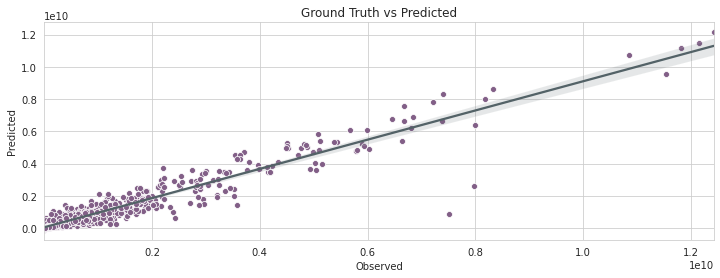

In [20]:
# plot observed target vs. predictions for out of the box rfr model
plot_predictions(X_train, y_train, base_model)

In [21]:
def plot_residuals(features, target, model):
    """Return plot of predictions vs.residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        model.predict(X_test), y_test, lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Predicted vs Residuals");

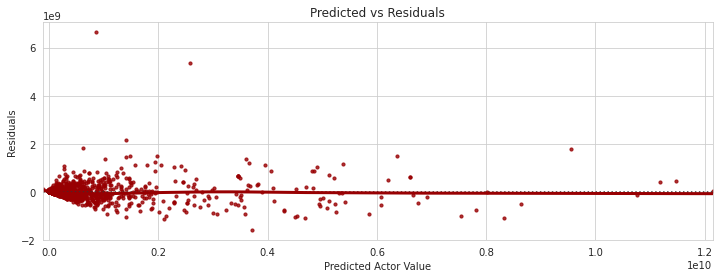

In [22]:
# plot predictions vs. residuals for out of the box rfr model
plot_residuals(X_train, y_train, base_model)

In [23]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    plt.ylim(0, 6e-9)
    
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residuals', 
        color=mp.colors(4))

    plt.ylabel('Frequency')

    plt.title('Distribution of Residuals');

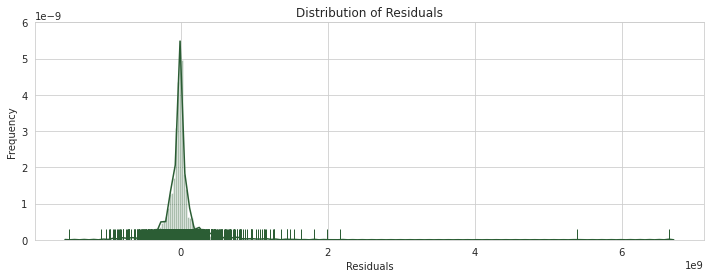

In [24]:
# plot residuals distribution for out of the box rfr model
plot_residual_distribution(X_train, y_train, base_model)

In [25]:
def plot_feature_importance(model):
    """Plots the features by importance to model"""
    ax = xgb.plot_importance(base_model)
    ax.figure.set_size_inches(12, 8)
    ax.plot();

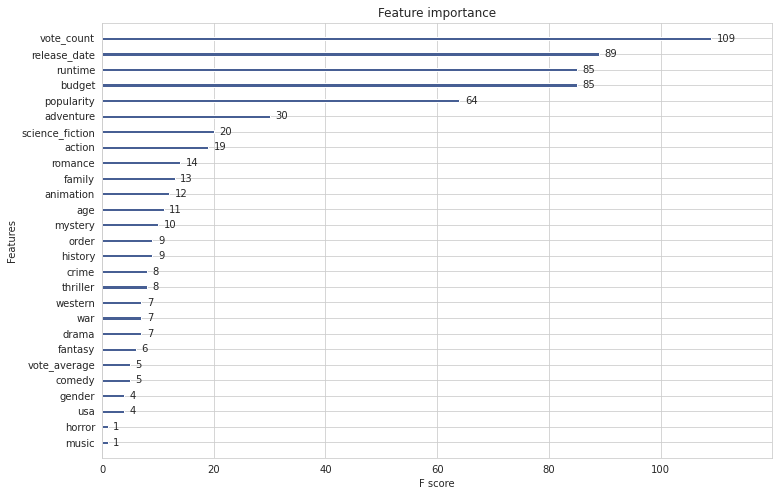

In [26]:
plot_feature_importance(base_model)

In [27]:
def plot_hp(train_scores, test_scores, param_lst):
    """Plots average errors and standard deviations over range of one hyperparameter"""
    # get scores stats
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # plot training scores
    sns.lineplot(x=param_lst, y=train_scores_mean, label="Training Score",
                 color=mp.colors(5), lw=2)
    plt.fill_between(param_lst, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color=mp.colors(5), lw=2)
    # plot test scores
    sns.lineplot(x=param_lst, y=test_scores_mean, label="Test Score",
                 color=mp.colors(0), lw=2)
    plt.fill_between(param_lst, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color=mp.colors(0), lw=2)
    
    plt.ylabel("RMSE", fontsize=15)
    
    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')

In [28]:
def plot_hyperparameters(features, target, model, grid):
    """Plots CV results over range of each hyperparameter"""
    # establish figure height
    num_subplots = 0
    for param_lst in grid.values():
        if len(param_lst) > 1:
              num_subplots += 1
    fig_height = num_subplots * 4
    # set subplots grid
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot errors over range of each hyperparameter
    count = 0   
    for param, param_lst in grid.items():
        # only score parameters that were given a range
        if len(param_lst) > 1:
            # get CV scores
            train_scores, test_scores = validation_curve(
                model, features, target, param_name=param, param_range=param_lst, 
                cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
            # convert scores to root-mean-square error
            train_rmse = np.sqrt(train_scores * -1)
            test_rmse = np.sqrt(test_scores * -1)
            # plot errors over range one hyperparameter
            count += 1
            plt.subplot(num_subplots, 1, count)
            
            plt.xlim(np.min(param_lst), np.max(param_lst))
            
            plot_hp(train_rmse, test_rmse, param_lst)
            
            plt.xlabel(param, fontsize=15)  
    plt.suptitle("Validation Curves with XGB", y=1.04, fontsize=20)
    plt.tight_layout();

I'll observe the errors for a various numbers of trees and some shrinkage values.

In [29]:
# create parameter search grid for range of number of trees
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(5, 300, num=60)]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

n_estimators [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 600 | elapsed:   18.0s remaining:   18.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   36.3s finished


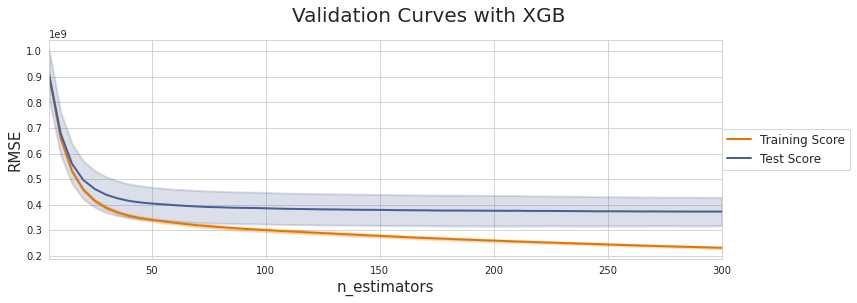

In [30]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [31]:
# create parameter search grid for range of learning rate
param_grid = {
    'learning_rate': np.linspace(0.01, 0.2, 20)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

learning_rate [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2 ]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 200 | elapsed:    4.7s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.1s finished


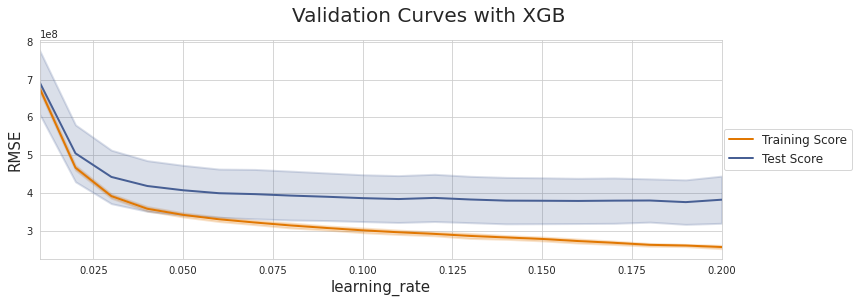

In [32]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

Some literature suggests to begin by finding the best product of number of trees and learning rate.<br>
I will call this product the model's tree flow.

I'll target different numbers of trees, while searching over a range of tree flows.

In [33]:
# create tree flow search grid for 10 trees
num_trees = 10
tree_flow_range = np.linspace(0.1, 1, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
learning_rate [0.01, 0.02, 0.030000000000000006, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [10]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


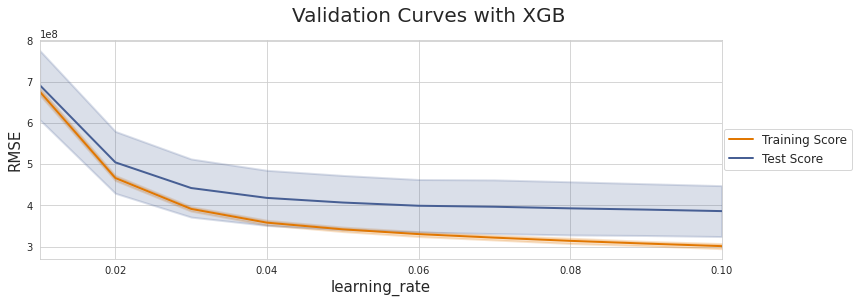

In [34]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [35]:
# create tree flow search grid for 100 trees
num_trees = 100
tree_flow_range = np.linspace(1, 10, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
learning_rate [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [100]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


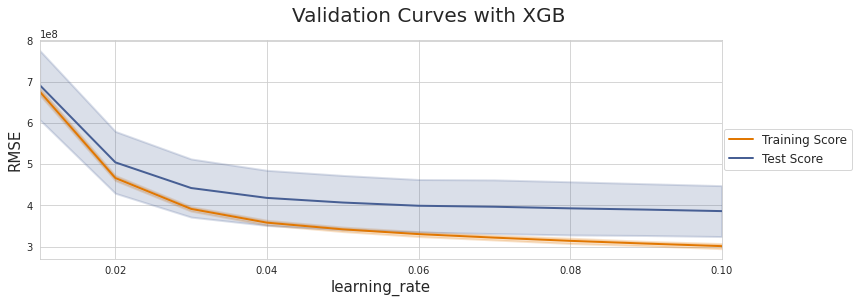

In [36]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [37]:
# create tree flow search grid for 500 trees
num_trees = 500
tree_flow_range = np.linspace(5, 50, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]
learning_rate [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [500]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


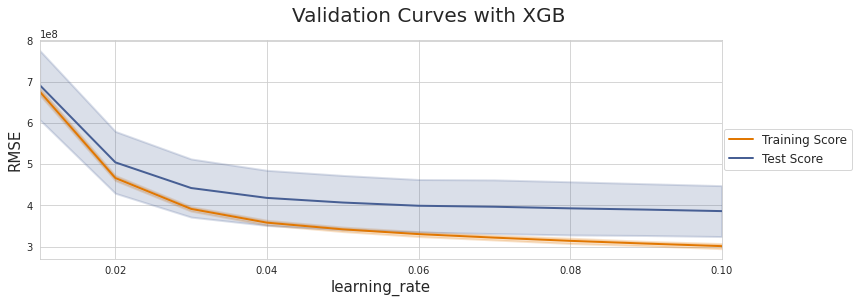

In [38]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

In [39]:
# create tree flow search grid for 1000 trees
num_trees = 1000
tree_flow_range = np.linspace(10, 100, 10)
# create parameter search grid
param_grid = {
    'learning_rate': (tree_flow_range / num_trees).tolist(),
    'n_estimators': [num_trees]
}

print('tree_flow', tree_flow_range)
for param, param_lst in param_grid.items():
    print(param, param_lst)

tree_flow [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
learning_rate [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators [1000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


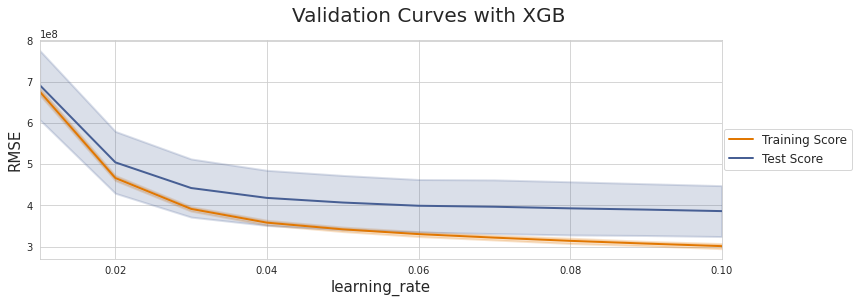

In [40]:
plot_hyperparameters(X_train, y_train, base_model, param_grid)

All 4 plots show the same results, despite the number of trees used.<br>
The optimal learning rate is independent of the number of trees used for this dataset.

 > **BAYESIAN HYPERPARAMETER SEARCH**

In [227]:
def objective(params):
    """Returns score for best model"""
    # assign data types to hyperparameters
    params = {
        'learning_rate': float(params['learning_rate']),
        'n_estimators': int(params['n_estimators'])
    }
    xgbr = xgb.XGBRegressor(**params)
    # get average score from 10 fold cross-validation
    results = cross_val_score(xgbr, X_train, y_train, scoring='neg_mean_squared_error', 
                                 cv=10, n_jobs=-1).mean()
    # convert cross-validation score to root mean squared error
    best_score = np.sqrt(results * -1)

    return {'loss': best_score, 
           'status': STATUS_OK}

In [553]:
def plot_param_search(trials, n_iters):
    """Plot iterations of optimization search for hyperparmeters"""
    # establish figure height (hyperparameters plus optimization plot)
    num_subplots = len(trials.idxs_vals[0]) + 1
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot features in dataset
    count = 1
    for key in trials.idxs_vals[0]:
        plt.subplot(num_subplots, 1, count)
        # plot hyperparameters
        plt.plot(range(1, len(trials.results) + 1), trials.idxs_vals[1][key], marker='o', color=mp.colors(4))
        # get values to plot
        best_loss = trials.best_trial['result']['loss']
        best_param = trials.best_trial['misc']['vals'][key][0]
        # mark off optimal hyperparameter value
        plt.hlines(best_param, 0, n_iters, linestyles = '--', 
                   label='Optimal Hyperparameter', colors=mp.colors(2))
        # get value for best hyperparametertrials
        best_val = trials.best_trial['misc']['vals'][key][0]
        # annotate best hyperparameter value
        if key != 'n_estimators':
            plt.text(n_iters, best_param, '{:,.6f}'.format(best_val), color=mp.colors(2))
        else:
            plt.text(n_iters, best_param, int(best_val), color=mp.colors(2))
        # mark iteration with optimal loss
        plt.plot(trials.best_trial['tid'] + 1, best_param, marker='*', ms=15, color='k')
        count += 1

        plt.xlabel('Iteration', fontsize=15)
        plt.ylabel(key, fontsize=15)
        plt.legend(bbox_to_anchor=(1.35, 0.5), loc=5, fontsize='large')

    plt.subplot(num_subplots, 1, count)
    plt.ylim(best_loss * 0.9, np.max(trials.losses()) * 1.1)
    # plot optimization of loss
    sns.lineplot(x=range(1, n_iters + 1), y=trials.losses(), marker='o')
    # mark off best loss
    plt.hlines(best_loss, 0, n_iters, linestyles = '--', 
               label='Best Loss', colors=mp.colors(5))
    # annotate optimal loss
    plt.text(n_iters, best_loss, '${:,.2f}'.format(best_loss), color=mp.colors(5))
    # mark iteration with optimal loss
    plt.plot(trials.best_trial['tid'] + 1, best_loss, marker='*', ms=15, color='k')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')

    plt.suptitle('Hyperparameter Optimization Sequence', y=0.93, fontsize=20);

In [561]:
def run_trial_batches(hp_space, n_blocks=10):
    """Runs informed grid search trails in blocks of 100 iterations"""
    # instantiate trials object
    trials = Trials()
    # set number of iterations
    block_size = 100
    # initialize loss variables
    last_best = 0
    batch_best = -1
    # run optimization search
    for batch in range(n_blocks):
        # enable early stop
        if last_best != batch_best:
            # save last batch optimal loss
            last_best = batch_best
            n_iters = block_size * (batch + 1)
            # run one batch
            best_result = fmin(fn=objective, space=hp_space, max_evals=n_iters, trials=trials, 
                       rstate=np.random.RandomState(27), algo=tpe.suggest)
            # save batch results to M.2
            pickle.dump(trials, open('xgbr_trials.pkl', 'wb'))
            # capture batch optimal loss
            batch_best = trials.best_trial['result']['loss']####
    # instantiate empty dict
    tpe_dict = defaultdict(list)
    # add desired dicts
    tpe_dict['loss'] = [d['loss'] for d in trials.results] 
    for key in trials.idxs_vals[0]:
        tpe_dict[key] = trials.idxs_vals[1][key]
    tpe_dict['iteration'] = range(1, len(trials.results) + 1)
    # create customized DataFrame
    tpe_df = pd.DataFrame(tpe_dict)
    # call optimization plotting function
    plot_param_search(trials, n_iters)
    
    return tpe_df

I will tune the learning rate and number of estimators, together.

100%|██████████| 200/200 [13:30<00:00,  4.05s/trial, best loss: 372162068.71880776]


,loss,learning_rate,n_estimators,iteration
96,3.721621e+08,0.145509,1593.0,97
184,3.726408e+08,0.050839,1857.0,185
176,3.730038e+08,0.042751,1881.0,177
33,3.734347e+08,0.102421,1406.0,34
175,3.734693e+08,0.037916,1732.0,176


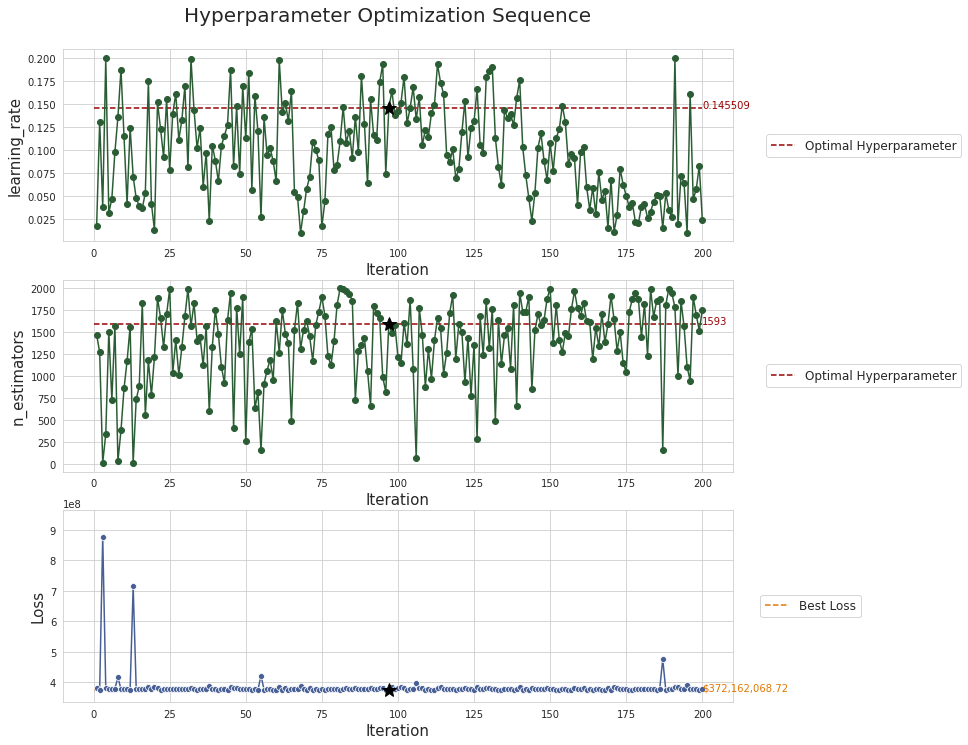

In [563]:
# create informed search grid  
hp_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.quniform('n_estimators', 1, 2000, 1)
}
# call optimization function
tpe_df_test = run_trial_batches(hp_space)
tpe_df_test.sort_values('loss').head()

100%|██████████| 200/200 [00:00<00:00, 1562124.39trial/s, best loss=?]


,loss,learning_rate,n_estimators,iteration
67,3.699232e+08,0.127699,790.0,67
115,3.707796e+08,0.128690,670.0,115
96,3.718397e+08,0.139803,790.0,96
161,3.720329e+08,0.113420,970.0,161
11,3.721895e+08,0.124517,785.0,11


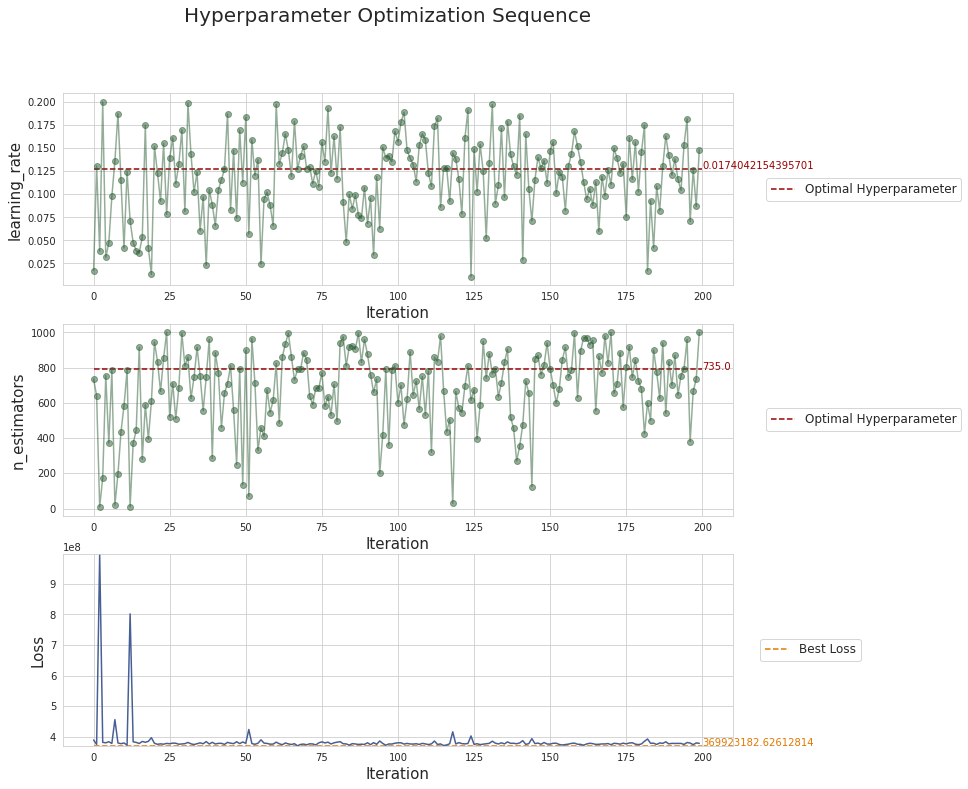

In [362]:
# create informed search grid  
hp_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.quniform('n_estimators', 5, 1000, 5)
}
# call optimization function
tpe_df_test = run_trial_batches(hp_space)
tpe_df_test.sort_values('loss').head()

100%|██████████| 200/200 [05:49<00:00,  1.75s/trial, best loss: 369722571.1068672]


,loss,learning_rate,n_estimators,iteration
67,3.697226e+08,0.127699,754.0,68
181,3.713627e+08,0.122992,412.0,182
96,3.721854e+08,0.139803,933.0,97
11,3.722480e+08,0.124517,782.0,12
113,3.724402e+08,0.144288,648.0,114


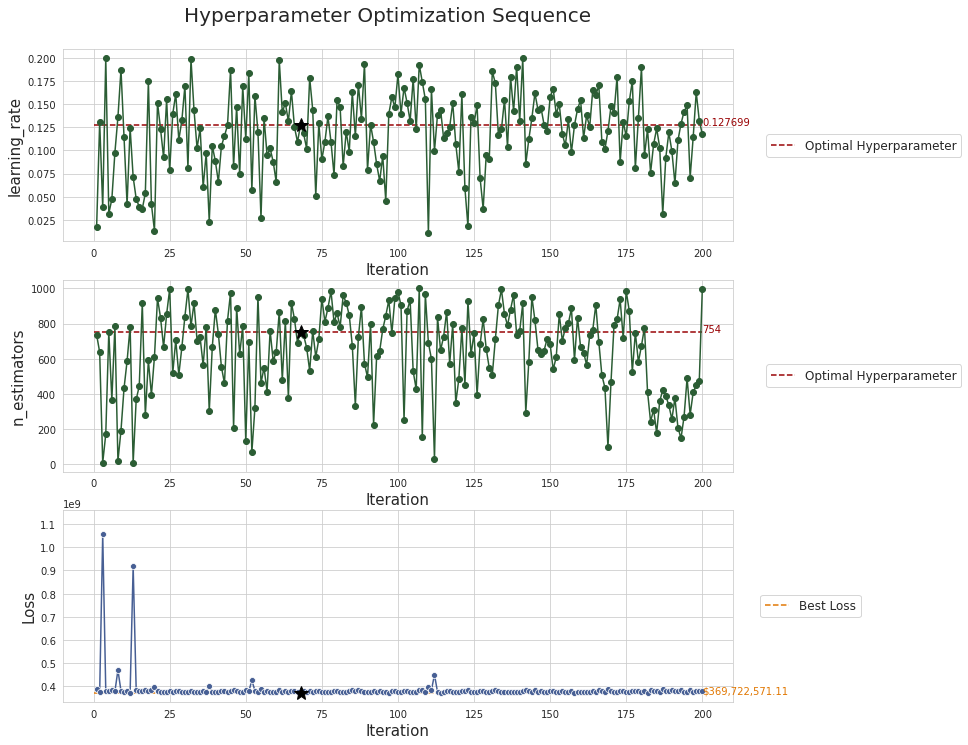

In [564]:
# create informed search grid  
hp_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.quniform('n_estimators', 1, 1000, 1)
}
# call optimization function
tpe_df_test = run_trial_batches(hp_space)
tpe_df_test.sort_values('loss').head()

100%|██████████| 20/20 [00:02<00:00,  6.77trial/s, best loss: 395192042.5094373]


,loss,learning_rate,n_estimators,iteration
1,3.951920e+08,0.130700,64.0,2
11,3.951920e+08,0.130700,64.0,12
16,3.998609e+08,0.097659,79.0,17
6,3.998609e+08,0.097659,79.0,7
9,4.129448e+08,0.115102,44.0,10


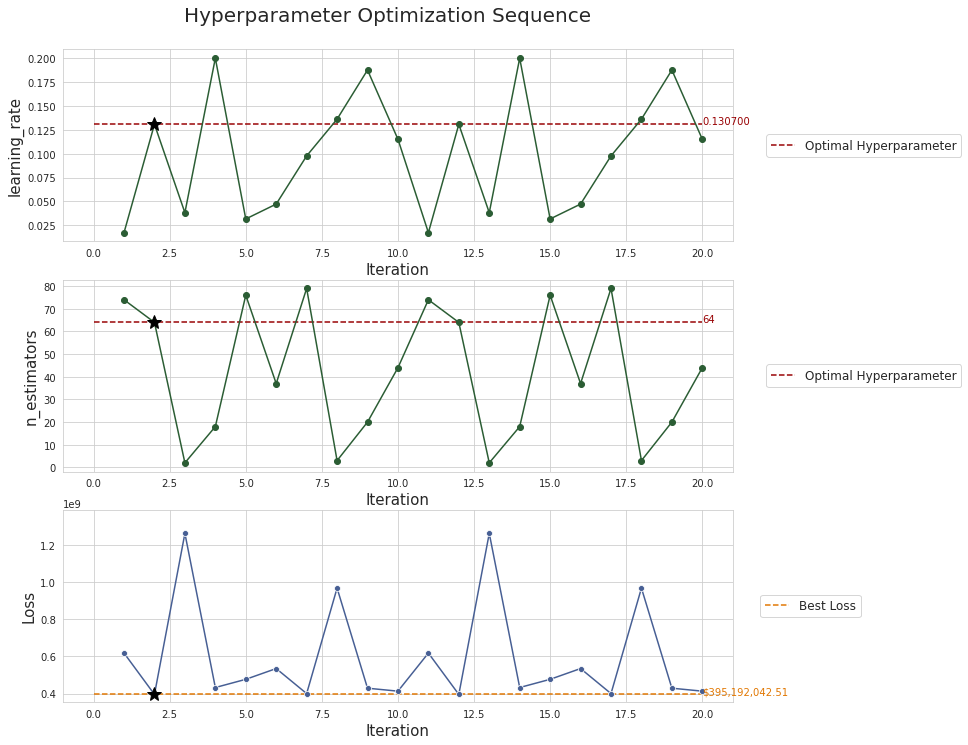

In [556]:
# create informed search grid 
hp_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.quniform('n_estimators', 1, 100, 1)
}
# call optimization function
tpe_df_test = run_trial_batches(hp_space)
tpe_df_test.sort_values('loss').head()

In [ ]:
# create informed search grid
hp_space_1 = {
#    'colsample_bylevel': np.linspace(0.1, 1, 10), 
#    'colsample_bynode': np.linspace(0.1, 1, 10),
#    'colsample_bytree': np.linspace(0.1, 1, 10), 
#    'gamma': [int(x) for x in np.linspace(1, 70, num=15)],
    'learning_rate': hp.uniform(0.01, 0.2),
#    'max_delta_step': [int(x) for x in np.linspace(5, 100, num=20)],
#    'max_depth': [int(x) for x in np.linspace(1, 10, 10)],
#    'min_child_weight': [int(x) for x in np.linspace(2, 100, num=11)],
#    'reg_alpha': [int(x) for x in np.linspace(5, 100, num=20)],
#    'reg_lambda': np.linspace(0.001, 20.0),
#    'subsample': np.linspace(0.1, 1, 10)
}

In [ ]:
    params = {'colsample_bylevel': int(params['colsample_bylevel']), 
             'colsample_bynode': int(params['colsample_bynode']), 
             'colsample_bytree': int(params['colsample_bytree']), 
             'gamma': int(params['gamma']), 
             'learning_rate': int(params['learning_rate']), 
             'max_delta_step': int(params['max_delta_step']), 
             'max_depth': int(params['max_depth']), 
             'min_child_weight': int(params['min_child_weight']), 
             'reg_alpha': int(params['reg_alpha']), 
             'reg_lambda': int(params['reg_lambda']), 
             'subsample': int(params['subsample'])}

In [146]:
from hyperopt import hp
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])
import hyperopt.pyll.stochastic
print (hyperopt.pyll.stochastic.sample(space))

('case 2', -2.589513448103773)


In [110]:
pd.DataFrame(trials)

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
0,2,0,None,"{'loss': 382328468.74930406, 'status': 'ok'}","{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2020-07-30 21:41:36.451,2020-07-30 21:41:37.115
1,2,1,None,"{'loss': 386366806.1081847, 'status': 'ok'}","{'tid': 1, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2020-07-30 21:41:37.117,2020-07-30 21:41:37.760
2,2,2,None,"{'loss': 658409948.4244012, 'status': 'ok'}","{'tid': 2, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2020-07-30 21:41:37.761,2020-07-30 21:41:38.363
3,2,3,None,"{'loss': 419366166.88742894, 'status': 'ok'}","{'tid': 3, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2020-07-30 21:41:38.366,2020-07-30 21:41:38.977
4,2,4,None,"{'loss': 386314500.34661984, 'status': 'ok'}","{'tid': 4, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2020-07-30 21:41:38.979,2020-07-30 21:41:39.578
...,...,...,...,...,...,...,...,...,...,...
95,2,95,None,"{'loss': 394298321.8013612, 'status': 'ok'}","{'tid': 95, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2020-07-30 21:42:36.936,2020-07-30 21:42:37.543
96,2,96,None,"{'loss': 385013650.6954799, 'status': 'ok'}","{'tid': 96, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2020-07-30 21:42:37.550,2020-07-30 21:42:38.167
97,2,97,None,"{'loss': 387627615.80045754, 'status': 'ok'}","{'tid': 97, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2020-07-30 21:42:38.175,2020-07-30 21:42:38.778
98,2,98,None,"{'loss': 385994208.3392118, 'status': 'ok'}","{'tid': 98, 'cmd': ('domain_attachment', 'FMin...",None,None,0,2020-07-30 21:42:38.782,2020-07-30 21:42:39.405


In [ ]:
    'colsample_bylevel': [1], 
    'colsample_bynode': [1],
    'colsample_bytree': [1], 
    'gamma': [0],
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_delta_step': [0],
    'max_depth': [3],
    'min_child_weight': [1],
    'reg_alpha': [0],
    'reg_lambda': [1],
    'subsample': [1]

In [ ]:
# create initial ranges to consider for parameter search grid
param_grid_1 = {
#    'colsample_bylevel': np.linspace(0.1, 1, 10), 
#    'colsample_bynode': np.linspace(0.1, 1, 10),
#    'colsample_bytree': np.linspace(0.1, 1, 10), 
#    'gamma': [int(x) for x in np.linspace(1, 70, num=15)],
#    'learning_rate': np.linspace(0.01, 0.2, 20),
#    'max_delta_step': [int(x) for x in np.linspace(5, 100, num=20)],
#    'max_depth': [int(x) for x in np.linspace(1, 10, 10)],
#    'min_child_weight': [int(x) for x in np.linspace(2, 100, num=11)],
#    'n_estimators': [int(x) for x in np.linspace(5, 300, num=60)],
#    'reg_alpha': [int(x) for x in np.linspace(5, 100, num=20)],
#    'reg_lambda': np.linspace(0.001, 20.0),
#    'subsample': np.linspace(0.1, 1, 10)
}
for param, param_lst in param_grid_1.items():
    print(param, param_lst)

In [ ]:
# old function without early stop
def run_trial_batches_old(hp_space, n_blocks=1):
    """Runs informed grid search trails in blocks of 100 iterations"""
    trials = Trials()
    # set number of iterations per batch
    block_size = 100
    n_iters = block_size * n_blocks
    # run optimization search
    for batch in range(n_blocks):
        best_result = fmin(fn=objective, space=hp_space, max_evals=n_iters, trials=trials, 
                   rstate=np.random.RandomState(27), algo=tpe.suggest)
    # save results to M.2
    pickle.dump(trials, open('xgbr_trials.pkl', 'wb'))
    # create trials object
    trials = pickle.load(open('xgbr_trials.pkl', 'rb'))
    # instantiate empty dict
    tpe_dict = defaultdict(list)
    # add desired dicts
    tpe_dict['loss'] = [d['loss'] for d in trials.results] 
    for key in trials.idxs_vals[0]:
        tpe_dict[key] = trials.idxs_vals[1][key]
    tpe_dict['iteration'] = range(1, len(trials.results) + 1)
    # create customized DataFrame
    tpe_df = pd.DataFrame(tpe_dict)
    # call optimization plotting function
    plot_param_search(trials, n_iters)
    
    return tpe_df

In [ ]:
# first run plotting function
def plot_hyperparameters_old(features, target, model, grid):
    """Plots CV results for each hyperparameter"""
    count = 0
    n_hp = len(grid.items())
    fig, axes = plt.subplots(nrows=n_hp, figsize=(12, 12))
    for param, param_lst in grid.items():
        # get CV scores
        train_scores, test_scores = validation_curve(
            model, features, target, param_name=param, param_range=param_lst, 
            cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
        # convert scores to root-mean-square error
        train_rmse = np.sqrt(train_scores * -1)
        test_rmse = np.sqrt(test_scores * -1)
        count += 1
        plt.subplot(n_hp, 1, count)
        plt.xlim(np.min(param_lst), np.max(param_lst))
        plot_hp(train_rmse, test_rmse, param_lst)
        plt.xlabel(param, fontsize=15)  
    plt.suptitle("Validation Curves with XGB", y=1.04, fontsize=20)
    plt.tight_layout();